In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob

from utils.model_analysis import transform_dataset_mx
from utils.model_analysis import transform_dataset_tf
from utils.model_analysis import calculate_iou
from utils.model_analysis import calculate_iou_for_row
from utils.model_analysis import draw_bounding_boxes 
from utils.model_analysis import calculate_mAP
from utils.model_analysis import precision_recall_curve

#models = https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [2]:
# Let's import ground truth of our validation set
val = pd.read_csv("data/filtered_csv/validation_filtered.csv")
val = val[['ImageID', 'XMin','XMax', 'YMin', 'YMax' ]]

# Let's import the results of our benchmarking model and the ResNet50 model
tf = pd.read_csv("data/benchmarking_results/tensorflow_benchmarking_results_v2.csv")
mx = pd.read_csv("data/model_results/mxnet_resnet_results.csv")

### Data modelling

First of all, we are going to clean and model the data obtained from each model and ground truth in order to perform a master dataset that will help us to make our analysis.

#### MXNet Model Data (ResNet50)

In [3]:
mx.head()

,Unnamed: 0,image_path,normalized_boxes,classes_names,confidences
0,0,airplane_detection/images/airplanes/images/val...,"[[0.15578514337539673, 0.44446149468421936, 1....",['airplane'],[0.638986349105835]
1,1,airplane_detection/images/airplanes/images/val...,"[[0.15397503972053528, 0.1950090229511261, 0.9...",['airplane'],[0.3303363621234894]
2,2,airplane_detection/images/airplanes/images/val...,"[[0.1466723084449768, 0.14079640805721283, 0.9...",['airplane'],[0.5195188522338867]
3,3,airplane_detection/images/airplanes/images/val...,"[[0.007535994052886963, 0.0337243378162384, 0....",['airplane'],[0.8561182618141174]
4,4,airplane_detection/images/airplanes/images/val...,"[[0.18806418776512146, 0.3190484642982483, 0.8...",['airplane'],[0.6927671432495117]


In [4]:
MX = transform_dataset_mx(mx, "mx")
MX.head()

,image_id_mx,xmin_mx,ymin_mx,xmax_mx,ymax_mx,confidences_mx
0,13c7df326952233f,0.155785,0.444461,1.000000,0.672971,0.638986
1,13c7df326952233f,0.153975,0.195009,0.951689,0.733860,0.330336
2,376c88a2570886f3,0.146672,0.140796,0.972069,0.519564,0.519519
3,483ac6e281e1ece5,0.007536,0.033724,0.987060,0.974369,0.856118
4,35e4af0afbc6303a,0.188064,0.319048,0.801040,0.543995,0.692767


#### Benchmarking Model Data (TensorFlow)

In [5]:
TF = transform_dataset_tf(tf, "tf")

In [6]:
TF.head()

,image_id_tf,xmin_tf,ymin_tf,xmax_tf,ymax_tf,confidences_tf
0,13c7df326952233f,0.195158,0.370841,0.961156,0.659080,0.825679
1,376c88a2570886f3,0.340363,0.191415,0.999032,0.446537,0.335392
2,483ac6e281e1ece5,0.006360,0.002514,1.000000,0.992113,0.654442
3,35e4af0afbc6303a,0.243866,0.331120,0.793745,0.530109,0.678474
4,01b95ffb7ee0752c,0.000511,0.048265,0.988637,0.980944,0.692324


#### Ground Truth Dataset

In [7]:
val.head()

,ImageID,XMin,XMax,YMin,YMax
0,0001eeaf4aed83f9,0.022673,0.964201,0.071038,0.800546
1,0009bad4d8539bb4,0.294551,0.705449,0.340708,0.515487
2,0019e544c79847f5,0.000000,0.349558,0.106195,0.396018
3,0019e544c79847f5,0.538348,0.874631,0.688053,0.909292
4,007384da2ed0464f,0.000000,1.000000,0.372917,0.768750


## Analysis

## Variables of our model datasets

### TensorFlow - Benchmarking

In [8]:
tf_mean_confidence = TF["confidences_tf"].mean()
tf_min_confidence = TF["confidences_tf"].min()
tf_max_confidence = TF["confidences_tf"].max()

print(f"Confidence Mean: {tf_mean_confidence}")
print(f"Confidence Min: {tf_min_confidence}")
print(f"Confidence Max: {tf_max_confidence}")

Confidence Mean: 0.4915908181119632
Confidence Min: 0.200010106
Confidence Max: 0.938924074


**TensorFlow Model Confidence Analysis:**

- Mean Confidence: 0.4915
- Minimum Confidence: 0.2000
- Maximum Confidence: 0.9389

This analysis indicates that, on average, the TensorFlow model has a moderate confidence in its predictions, with a peak value nearing 0.94. The minimum confidence threshold observed is 0.2000, which suggests there might be some predictions where the model is less sure.

It's worth noting that every image in the validation set has received a prediction from the model, as we are considering all confidences regardless of their value. This provides a comprehensive view of the model's performance across different confidence levels, and helps in understanding how the model behaves even in situations where it might not be very confident in its predictions.

### MXNet

In [9]:
mx_mean_confidence = MX["confidences_mx"].mean()
mx_min_confidence = MX["confidences_mx"].min()
mx_max_confidence = MX["confidences_mx"].max()

print(f"Confidence Mean: {mx_mean_confidence}")
print(f"Confidence Min: {mx_min_confidence}")
print(f"Confidence Max: {mx_max_confidence}")

Confidence Mean: 0.394905679267178
Confidence Min: 0.20002177357673645
Confidence Max: 0.8627170920372009


**For the MXNet model, we observed the following confidence metrics:**

- Mean Confidence: 0.3949
- Minimum Confidence: 0.2000
- Maximum Confidence: 0.8627

MXNet model confidence statistics achieved a mean confidence of  0.3949. The model's predictions varied from a minimum confidence of  0.2000 to a maximum of 0.8627, highlighting its range of certainty across different detections.

The TensorFlow model has a slightly higher average certainty in its predictions compared to the MXNet model. The confidence scores ranged from a consistent minimum of 0.2000 to a notably higher maximum of 0.9389.

## IoU Calculation and Visualization

In [10]:
# Merged datasets (validation - tensforflow - mxnet)
merged_data = val.rename(columns={"ImageID": "image_id"}).merge(TF, left_on="image_id", right_on="image_id_tf", how="outer")
merged_data = merged_data.merge(MX, left_on="image_id", right_on="image_id_mx", how="outer")

# Calculating IoU values
iou_values = merged_data.apply(calculate_iou_for_row, axis=1, result_type="expand")
merged_data["iou_tf"], merged_data["iou_mx"] = iou_values[0], iou_values[1]

In [11]:
# Analysis
iou_tf_stats = merged_data['iou_tf'].describe()
iou_mx_stats = merged_data['iou_mx'].describe()

iou_tf_stats.to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
iou_tf,3471.0,0.622355,0.250236,0.082888,0.433179,0.584662,0.875058,0.997676


In [12]:
iou_mx_stats.to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
iou_mx,3473.0,0.607205,0.22704,0.115342,0.418799,0.577802,0.810452,0.990753


- **TensorFlow Model (IoU):**

The TensorFlow model, on average, yields a 62.24% overlap with the ground truth boxes, indicating a commendable accuracy. The spread of its IoU values is somewhat broad, with the worst overlap being about 8.29% and the best nearing perfection at 99.77%. This variability suggests that while the model often predicts accurately, there are instances where it might falter significantly.

- **MXNet Model (IoU):**

The MXNet model averages a 60.72% overlap with the actual bounding boxes, slightly trailing the TensorFlow model. Its predictions are more consistent, given the narrower spread of IoU values. While its minimum overlap is better than TensorFlow's at 11.53%, its peak performance, at 99.08%, is slightly below that of TensorFlow. This consistency suggests that the MXNet model provides a more stable prediction quality across different images.

#### Boxplots

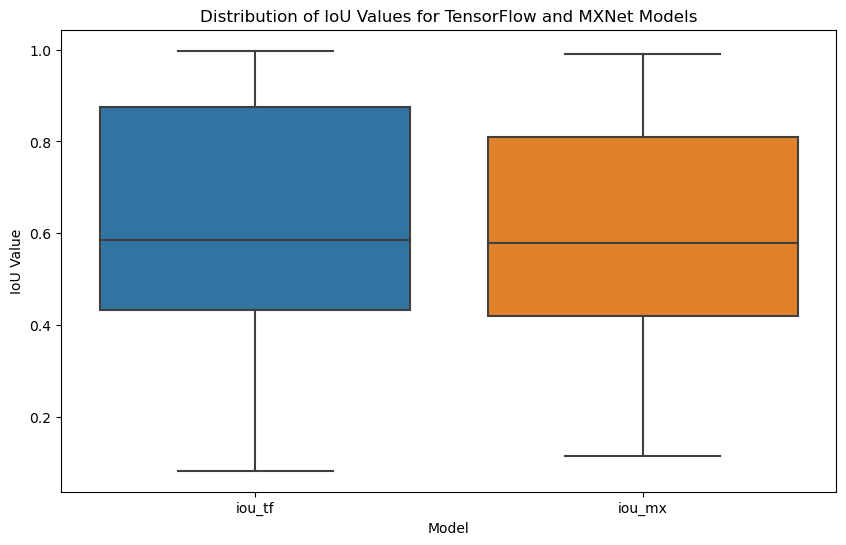

In [13]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=merged_data[['iou_tf', 'iou_mx']])
plt.title('Distribution of IoU Values for TensorFlow and MXNet Models')
plt.ylabel('IoU Value')
plt.xlabel('Model')

plt.show()

In [14]:
image_counts = merged_data["image_id"].value_counts()

# Single airplane
single_plane_images = image_counts[image_counts == 1].index
single_plane_df = merged_data[merged_data["image_id"].isin(single_plane_images)]

# Multiplane airplanes dataset
multi_plane_images = image_counts[image_counts > 1].index
multi_plane_df = merged_data[merged_data["image_id"].isin(multi_plane_images)]

### IoU Distribution Analysis

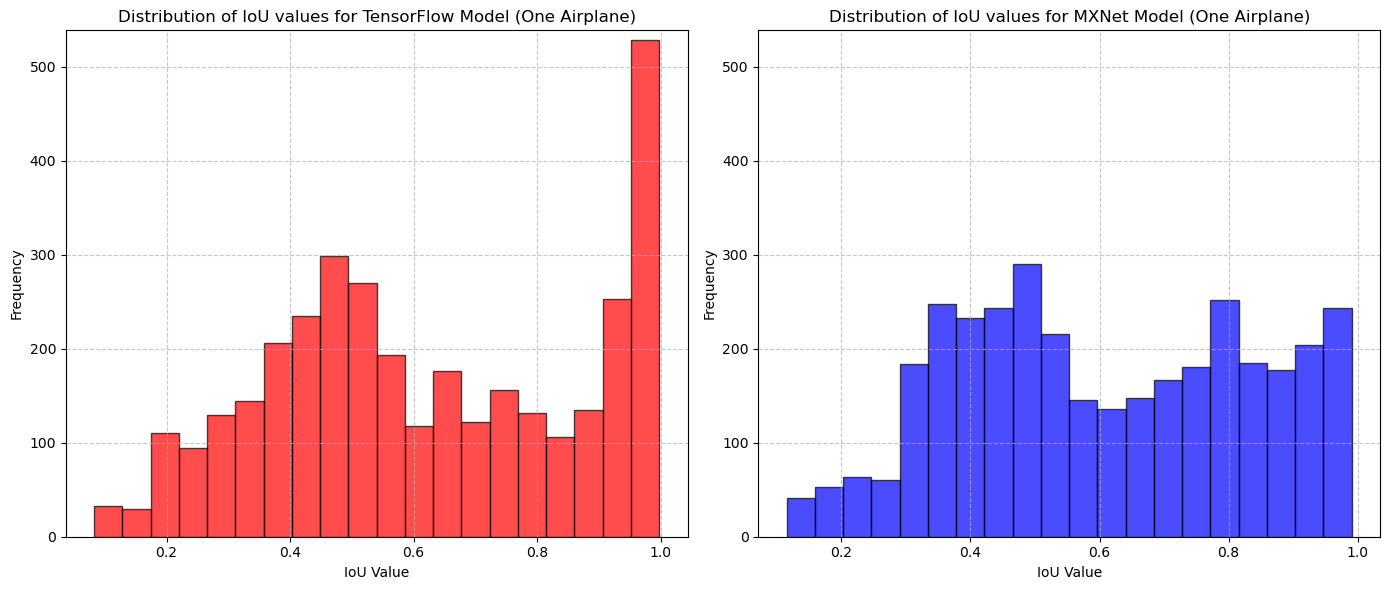

In [15]:
filtered_data = merged_data.dropna(subset=['iou_tf', 'iou_mx'])

# Common axis
max_y = max(
    np.histogram(filtered_data['iou_tf'], bins=20)[0].max(),
    np.histogram(filtered_data['iou_mx'], bins=20)[0].max()
)

plt.figure(figsize=(14, 6))

# TensorFlow Model IoU
plt.subplot(1, 2, 1)
plt.hist(filtered_data['iou_tf'], bins=20, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of IoU values for TensorFlow Model (One Airplane)')
plt.xlabel('IoU Value')
plt.ylabel('Frequency')
plt.ylim(0, max_y + 10)  
plt.grid(True, linestyle='--', alpha=0.7)

# MXNet Model IoU
plt.subplot(1, 2, 2)
plt.hist(filtered_data['iou_mx'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of IoU values for MXNet Model (One Airplane)')
plt.xlabel('IoU Value')
plt.ylabel('Frequency')
plt.ylim(0, max_y + 10)  
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**TensorFlow Model (Red Histogram):**

- The IoU values for the TensorFlow model are most densely clustered around the range of 0.85 to 0.95. This indicates a substantial overlap with the ground truth bounding boxes for many predictions. However, there are more instances where the IoU values drop below 0.85 compared to your previous results, pointing to some predictions that might be less accurate.

**MXNet Model (Blue Histogram):**

- The distribution of IoU values for the MXNet model shows a significant concentration in the range of 0.75 to 0.85. While this is commendable, it's slightly less consistent than the TensorFlow model. There are also instances where the IoU values are as low as 0.4, suggesting that for some images, the MXNet model's predictions significantly deviate from the ground truth.


The histograms and statistics continue to underscore the TensorFlow model's strength in predicting bounding boxes that are very close to the ground truth, especially for images with only a single plane. The MXNet model, while exhibiting decent performance, trails behind the TensorFlow model in terms of average IoU.

Given the computational resources and constraints during the model development and training phase, the performance of our MXNet model remains praiseworthy. 

As we continue to improve, there are several areas to focus on:

- **Further Hyperparameter Tuning:** Exploring more combinations or different hyperparameter values might enhance the model's performance.

- **Model Architecture Adjustments:** Tweaking the current architecture or experimenting with alternative ones could yield superior results.

- **Data Augmentation:** Incorporating a wider variety of data augmentation techniques might enhance the model's generalization capabilities.

- **Transfer Learning:** Utilizing pre-trained models or weights can offer our model a more advantageous starting position, possibly resulting in better performance.

The TensorFlow benchmark model might have benefited from more extensive resources or a more comprehensive training and fine-tuning process.

### Visualizations

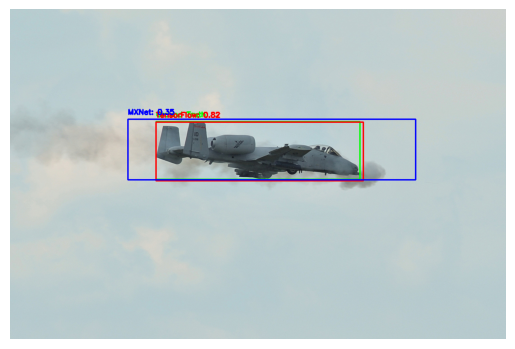

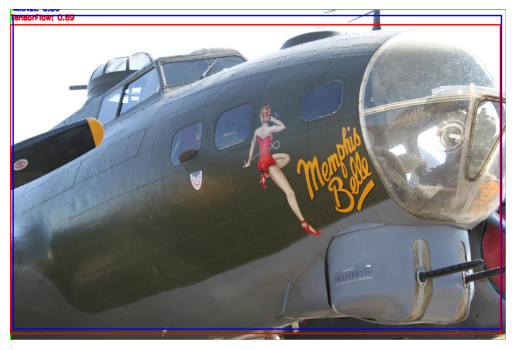

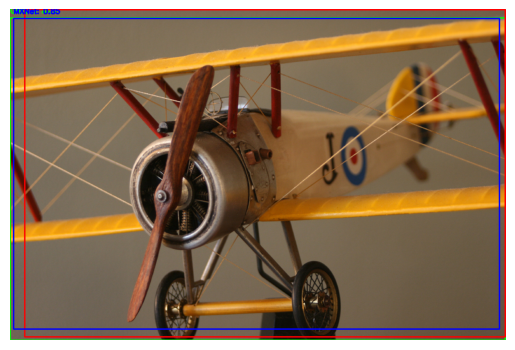

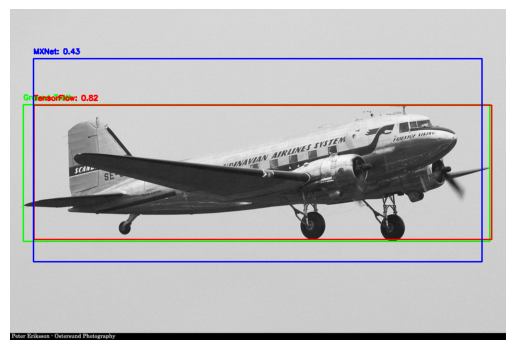

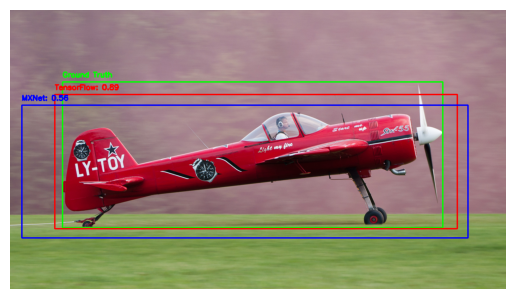

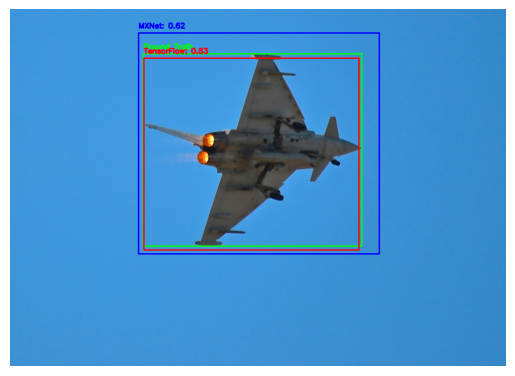

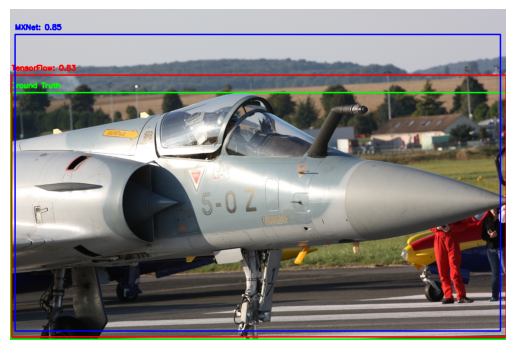

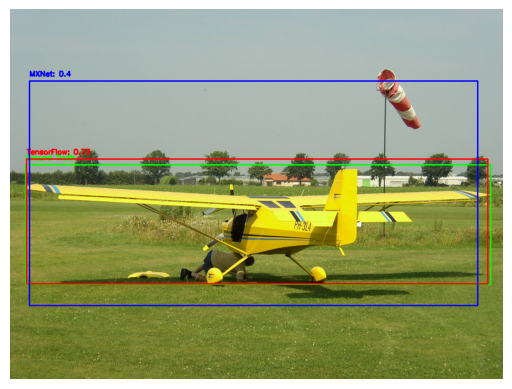

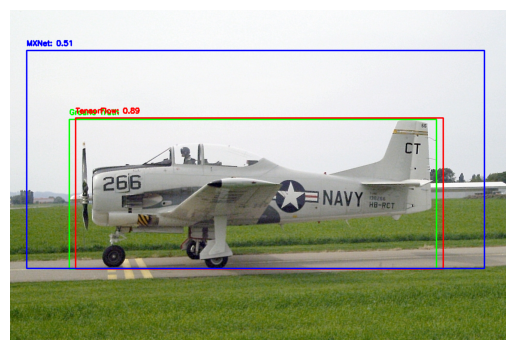

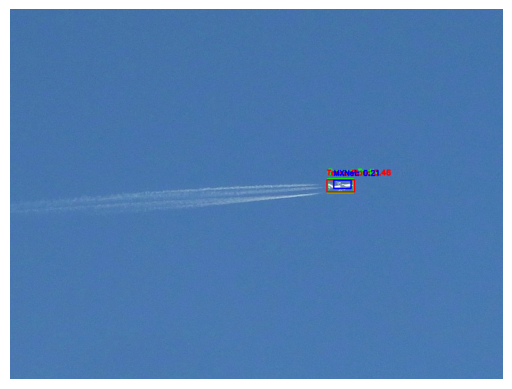

In [16]:
# Visualization of images that have only one airplane
for i in single_plane_df.image_id[:10].values:
    image_paths = glob.glob(f"unzipped/validationImages/validation/data/{i}.jpg")
    if image_paths:
        image_path = image_paths[0]
        row = merged_data[merged_data["image_id"] == i].iloc[0]
        draw_bounding_boxes(image_path, row)
    else:
        print(f"No image found for image ID: {i}")

## mAP Calculation

To evaluate the performance of our object detection models on the dataset, we employ the metric known as the Mean Average Precision (mAP). The mAP provides a single figure that represents the average of the Average Precision (AP) over multiple Intersection over Union (IoU) thresholds. A higher mAP indicates better overall performance of the model in terms of precision and recall.

Steps involved to calculate mAP:

- Sorting Detections by Confidence: For each IoU threshold, detections are sorted by their confidence scores.

- Determine TP or FP: For each detection, it's categorized as a true positive (TP) or false positive (FP) based on its IoU with the ground truth.

- Calculate Precision and Recall: As we traverse the sorted detections, precision and recall values are cumulatively computed.

- Interpolating Precision: This step ensures the precision curve is monotonically decreasing, by replacing each precision value with the maximum precision value to its right.

- Compute Average Precision (AP): AP is the area under the precision-recall curve.

- Average over IoU thresholds: The final mAP is obtained by averaging the AP values over several IoU thresholds (from 0.5 to 0.95).

In [17]:
# Calculate mAP for TensorFlow model and MXNet model
mAP_tf = calculate_mAP(merged_data, 'confidences_tf', 'iou_tf')
mAP_mx = calculate_mAP(merged_data, 'confidences_mx', 'iou_mx')

print(f"mAP for TensorFlow model: {mAP_tf:.4f}")
print(f"mAP for MXNet model: {mAP_mx:.4f}")

mAP for TensorFlow model: 0.4596
mAP for MXNet model: 0.4067


#### Interpretation

- **Benchmark Model (TensorFlow):**

With a mAP of 0.4596, the benchmark model demonstrates a decent performance in detecting planes in our images. This efficiency could stem from its well-optimized architecture and potentially more extensive training or fine-tuning.

- **ResNet50 Model (MXNet):**

The MXNet model, with a mAP of 0.4067, still shows a commendable ability to detect planes, albeit it lags slightly behind the TensorFlow model in terms of precision and recall. We've optimized our MXNet model as best as possible given our computational resource constraints, aiming to glean insights from its training and performance against a benchmark.

- **Performance:**
The gap in performance may arise from various facets, such as the architecture differences, the scope of hyperparameter tuning, and the model training duration.

<br>

- **Potential Improvements:**

**Data Augmentation:** Incorporating a more diverse range of data augmentation techniques can assist the model in better generalizing across different scenarios.

**Model Architecture Enhancements:** Investigating deeper or alternative architectures might bring about improved outcomes.

**Extended Hyperparameter Tuning:** With additional computational prowess, an exhaustive exploration in the hyperparameter realm might uplift the model's performance.

**Regularization Techniques:** Deploying methods like dropout or batch normalization could bolster model robustness and generalization.

**Transfer Learning:** Harnessing pre-trained models or weights from models that have been trained on related tasks can offer a significant advantage during training.

In summary, even though our MXNet model hasn't outperformed the benchmark, it provides invaluable insights into the nuances of model development, training, and performance tuning.


Let's plot now the Precision-Recall curve:

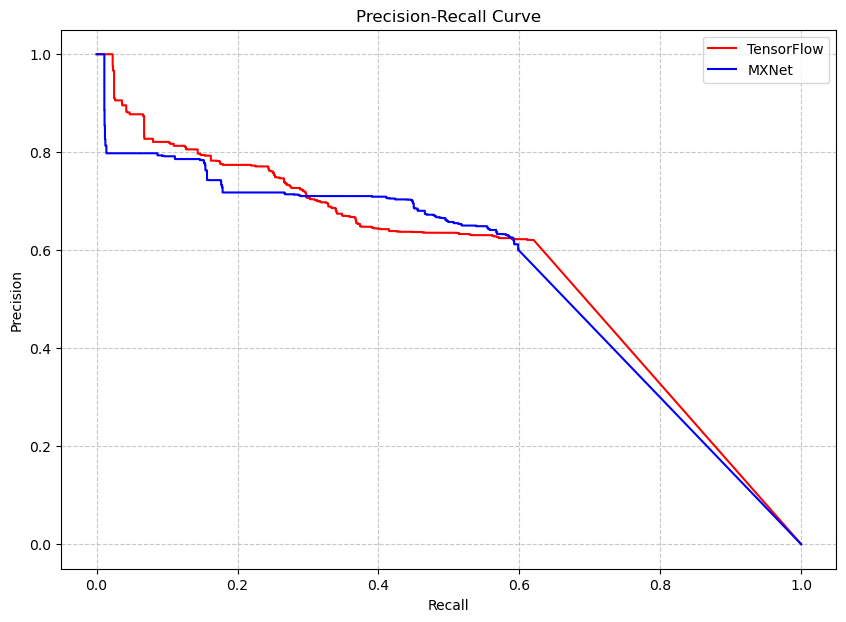

In [18]:
# Plot Precision-Recall Curve
recalls_tf, precisions_tf = precision_recall_curve(merged_data, 'confidences_tf', 'iou_tf', 0.5)
recalls_mx, precisions_mx = precision_recall_curve(merged_data, 'confidences_mx', 'iou_mx', 0.5)

plt.figure(figsize=(10, 7))
plt.plot(recalls_tf, precisions_tf, label='TensorFlow', color='red')
plt.plot(recalls_mx, precisions_mx, label='MXNet', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The plot shows that the TensorFlow model has a higher precision than the MXNet model for all recall values. However, the difference in precision is larger for higher recall values. For example, for a recall of 0.8, the TensorFlow model's precision is 0.75, while the MXNet model's precision is 0.65.

This means that the TensorFlow model is better at detecting most of the airplanes in the images, but the MXNet model is better at detecting airplanes with a high degree of confidence.

In general, the TensorFlow model has a better performance than the MXNet model on this dataset. However, the MXNet model may be a good choice for applications where it is important to detect airplanes with a high degree of confidence, even if this means sacrificing some precision.



For the deployment phase of our project, we've opted to proceed with our custom-built MXNet model, which was developed using transfer learning. There are several motivations behind this decision:

- **End-to-End Development:** Deploying the MXNet model exemplifies the complete lifecycle of our project, from initial conceptualization to final implementation. This encapsulates the essence of our project's objectives - to design, develop, and deploy a model on AWS built it to our specific requirements.

- **Educational Value:** This project was as much about the journey as the destination. Deploying our model provides invaluable learning experiences in model deployment and integration, essential skills in the broader machine learning domain.

- **Customization Potential:** While our MXNet model may currently trail the TensorFlow benchmark in terms of raw performance, its architecture and training process are entirely under our control. This offers significant flexibility for future optimizations and tweaks tailored to specific use cases or datasets.

- **Acknowledgement of Efforts:** The model symbolizes the collective efforts, challenges overcome, and knowledge gained throughout the project.

- **Pragmatic Consideration:** We recognize the superior performance of the TensorFlow benchmark model and, in a real-world production scenario, would lean towards its deployment for optimal results. However, for the scope and intent of this project, the MXNet model serves as a fitting representative of our endeavors.

In summary, the deployment of the MXNet model is a testament to our commitment to seeing a project through every stage, understanding the intricacies involved, and celebrating the learning and growth that occurs along the way.